In [ ]:
#GOAl : check shear SNR prediction vs CLMM mock data

## TODO 
- [x] Understand differences in model
- [ ] Understand difference in Ngal per bin (Ngal higher in my code with a foctor ~4, that seems to change only with cosmo)
- [ ] Understand difference in SNR 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from magnification_library import *
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

import sys
sys.path.append('../CLMM/examples/support')
import mock_data as mock
import clmm.modeling as mod
from clmm.plotting import plot_profiles
from clmm import utils 
from clmm.polaraveraging import compute_tangential_and_cross_components, make_binned_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.io import ascii
from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy import stats, interpolate

In [3]:
#define cosmology
params = {'flat': True, 'H0': 70., 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.80, 'ns': 0.963}

#astropy
cosmo = FlatLambdaCDM(H0=params['H0'], Om0=params['Om0'], Ob0=params['Ob0'], Tcmb0=0, Neff=3.04)

#ccl like
cosmo_ccl = mod.cclify_astropy_cosmo(cosmo)


In [4]:
#Source galaxies properties

#s_e = 0.26, n_e = 26 / u.arcmin**2 #https://arxiv.org/pdf/1305.0793.pdf


#SHEAR LSST
s_e = 0.01 #0.25
n_e = 30. / u.arcmin**2
#shear_pdz = pzfxn

def shear_pdz(z):
    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3), 0, np.inf)[0]
    return trunc_pdf(z, 1.24, 1.01, 0.51, 0, 3)/norm   

#def shear_pdz(z):
#    norm =quad(lambda z: trunc_pdf(z, 1.24, 1.01, 0.51, 0.3, 3), 0, np.inf)[0]
#    return trunc_pdf(z, 1.24, 1.01, 0.51, 0.3, 3)/norm   


In [5]:
cluster_m = 5.e14
cluster_z = 0.1
concentration = 3.
Delta = 200 # mass definition with respect to critical overdensity
cluster_ra = 0.0
cluster_dec = 0.0
zsrc_min=cluster_z+0.1

In [6]:
N_stack = 10

In [7]:
mock_catalogs = []

for i in range(N_stack):
    mock_catalogs.append(mock.generate_galaxy_catalog(
    cluster_m*cosmo.h, cluster_z, concentration, cosmo,  Delta, 'chang13', halo_profile_model='nfw', zsrc_min=zsrc_min,
    zsrc_max=3.0, field_size=10*cosmo.h, shapenoise=s_e, photoz_sigma_unscaled=None, ngal_density=n_e.value))

In [8]:
mock_catalogs[i]['ra'].size

111966

In [10]:
boxsize = cosmo.arcsec_per_kpc_proper(cluster_z).to(u.deg/u.Mpc)*5

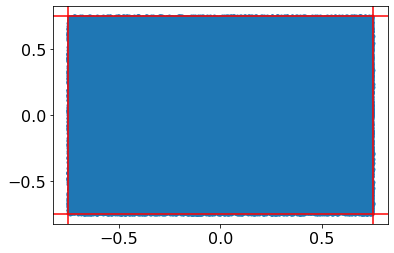

In [11]:
plt.plot(mock_catalogs[i]['ra'], mock_catalogs[i]['dec'],'.')


plt.axvline(boxsize.value,color='red')
plt.axvline(-boxsize.value,color='red')

plt.axhline(boxsize.value,color='red')
plt.axhline(-boxsize.value,color='red')

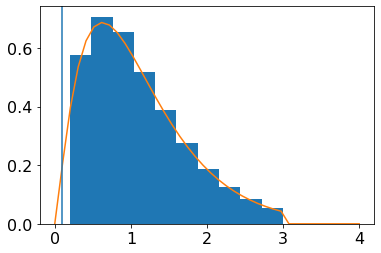

In [12]:
z_s = np.linspace(0.001, 4, 40)
plt.hist(mock_catalogs[i]['z'], density=True);
plt.plot(z_s, shear_pdz(z_s), label = 'shear LSST')

plt.axvline(cluster_z)

In [13]:
cls = []

for i in range(N_stack):
    cls.append(GalaxyCluster('mock', cluster_ra, cluster_dec, 
                               cluster_z, mock_catalogs[i]))

In [14]:
radial_unit, rmin, rmax, nbins, method = 'Mpc', 0.2, 5, 5, 'evenlog10width'
binedges = make_bins(rmin, rmax, nbins=nbins, method=method)

In [15]:
mock_profiles = []

for i in range(N_stack):

    theta, g_t, g_x = compute_tangential_and_cross_components(cls[i], geometry="flat")
    mock_profiles.append(make_binned_profile(cls[i], "radians", "Mpc", bins=binedges, cosmo=cosmo, include_empty_bins=True, gal_ids_in_bins=True))

/pbs/throng/lsst/users/mricci/desc/CLMM/clmm/polaraveraging.py:243: UserWarning: Using the flat-sky approximation with separations >1 deg may be inaccurate
  warnings.warn("Using the flat-sky approximation with separations >1 deg may be inaccurate")
/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


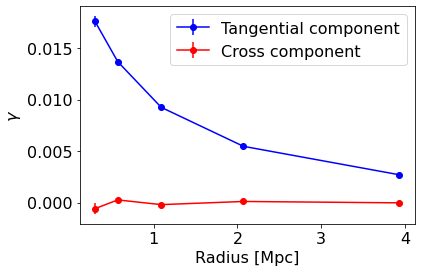

In [16]:
fig, ax = plot_profiles(cls[i])

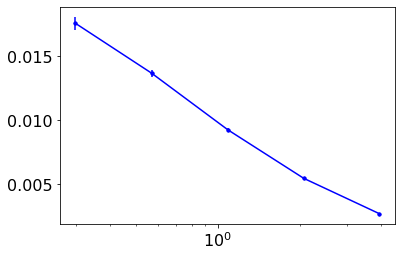

In [17]:
plt.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt'],'b.-')
plt.errorbar(mock_profiles[i]['radius'], mock_profiles[i]['gt'], yerr =mock_profiles[i]['gt_err'], fmt='b.')

plt.xscale('log')

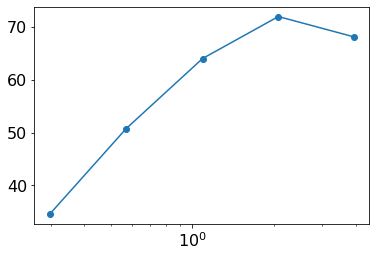

In [18]:
plt.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt']/mock_profiles[i]['gt_err'],'o-')
plt.xscale('log')

In [19]:
dict_profile = {'reduced shear': \
                {'model_func':  mod.predict_tangential_shear, \
                'noise_func': lambda Ngal: noise_shear(Ngal , s_e),\
                'model_arg': 1., \
                'source_pdz': shear_pdz,\
                'source_density': n_e}}

In [20]:
lens_redshift = cluster_z
profile_type = "reduced shear"

In [21]:
bin_center, bin_edges, model, noise = profile_determination(rmin, rmax, radial_unit , lens_redshift, cluster_m , profile_type , dict_profile, cosmo, nbins, method=method, conc=concentration, delta_mdef=200, zinf=1e10)

In [22]:
bin_center, binedges, Ngal = compute_source_number_per_bin(rmin, rmax, radial_unit, lens_redshift, dict_profile[profile_type]['source_pdz'], dict_profile[profile_type]['source_density'], nbins, method, cosmo)

In [28]:
Ngal

array([   772.08322385,   2797.95109657,  10139.4902738 ,  36744.48175254,
       133158.26563307])

In [26]:
(1/u.arcmin**2) * (u.arcmin/u.h)**2

<Quantity 1. 1 / h2>

In [25]:
for i in range(N_stack ):
    print ([len(cls[i].profile['gal_id'][k]) for k in range(cls[i].profile['radius'].size)])

[385, 1322, 4951, 17497, 63806]
[343, 1336, 4819, 17741, 63768]
[357, 1372, 4800, 17455, 63670]
[357, 1372, 4905, 17810, 63585]
[361, 1311, 4900, 17482, 63819]
[354, 1363, 4933, 17403, 63633]
[368, 1270, 4882, 17395, 63873]
[401, 1349, 4865, 17475, 63644]
[374, 1353, 4820, 17517, 63561]
[384, 1411, 4791, 17448, 63891]


In [423]:
cls[4].profile['radius']

0.29914692717461305
0.5682361658458411
1.0861932601512958
2.066802078900026
3.9375455104624093


In [ ]:
for i in range(N_stack ):
    print ([Ngal[k]/len(cls[i].profile['gal_id'][k]) for k in range(cls[i].profile['radius'].size)])

In [281]:
rr = np.logspace(-1, np.log10(5), 100)
zinf=1e10


Bs_mean = compute_Bs_mean(cluster_z, zinf, dict_profile[profile_type]['source_pdz'], cosmo)

for i in range(N_stack ):

    gt_model1 = Bs_mean  * mod.predict_reduced_tangential_shear(rr*cosmo.h,
                                                  cluster_m*cosmo.h, concentration,
                                                  cluster_z, zinf, cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

In [282]:
N_stack = 10
gt_model2 = np.zeros((cls[0].profile['radius'].size, N_stack))

for i in range(N_stack ):
    gt_model2[:, i] = mod.predict_reduced_tangential_shear(cls[i].profile['radius']*cosmo.h,
                                                  cluster_m*cosmo.h, concentration,
                                                  cluster_z, cls[i].profile['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

In [283]:
gt_model3 = np.zeros((len(cls[0].profile['radius']*cosmo.h), N_stack))

for i in range(N_stack ):
    for k in range(len(cls[i].profile['radius']*cosmo.h)):

        gt_model3[k,i] = np.mean(mod.predict_reduced_tangential_shear(cls[i].profile['radius'][k]*cosmo.h,
                                                  cluster_m*cosmo.h, concentration,
                                                  cluster_z, mock_catalogs[i]['z'], cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw'))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


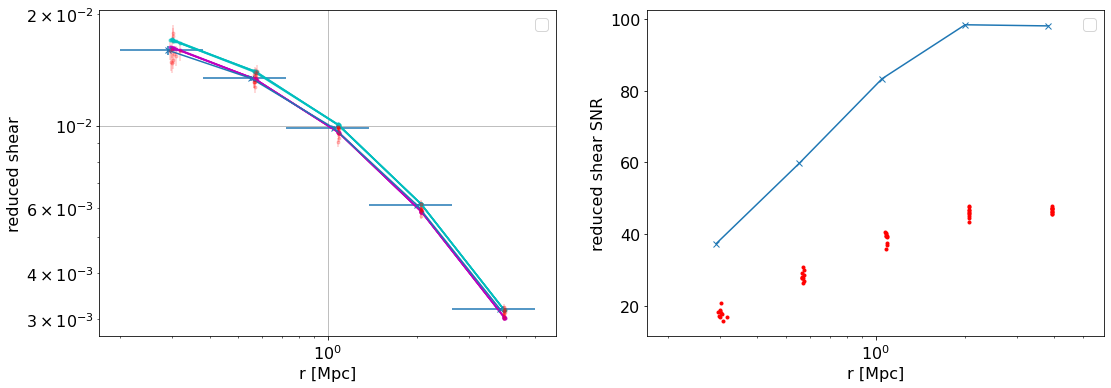

In [284]:
fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(18,6), sharex=True, sharey=False)


ax1.errorbar(bin_center, model, xerr = [bin_center - bin_edges[0:-1], bin_edges[1:] - bin_center], yerr = noise ,fmt='-x')
ax2.plot(bin_center, model/(noise*np.sqrt(1.)), 'x-')

ax1.legend()
ax2.legend()

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.grid()

ax1.set_ylabel(profile_type)
ax1.set_xlabel('r [' + radial_unit + ']');

ax2.set_ylabel(profile_type + " SNR")
ax2.set_xlabel('r [' + radial_unit + ']');

[ax1.plot(cls[i].profile['radius'], gt_model2[:, i],'.-c',alpha=0.5) for i in range(N_stack)]
[ax1.plot(cls[i].profile['radius'], gt_model3[:,i],'.-m',alpha=0.5) for i in range(N_stack)]

[ax1.errorbar(mock_profiles[i]['radius'], mock_profiles[i]['gt'], yerr =mock_profiles[i]['gt_err'], fmt='r.',alpha=0.2) for i in range(N_stack)]
[ax2.plot(mock_profiles[i]['radius'], mock_profiles[i]['gt']/mock_profiles[i]['gt_err'],'r.') for i in range(N_stack)];


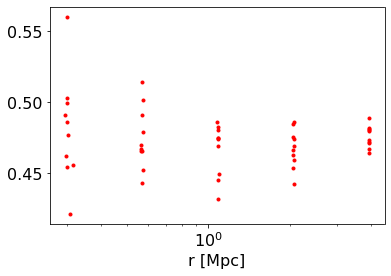

In [285]:
plt.xlabel('r [' + radial_unit + ']');
[plt.plot(mock_profiles[i]['radius'], (mock_profiles[i]['gt']/mock_profiles[i]['gt_err'])/(model/(noise*np.sqrt(1.))),'r.') for i in range(N_stack)];
plt.xscale('log')

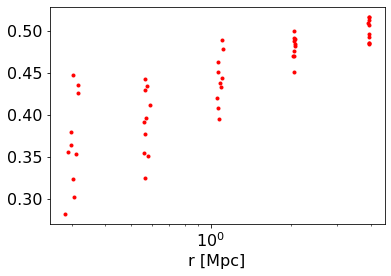

In [254]:
plt.xlabel('r [' + radial_unit + ']');
[plt.plot(mock_profiles[i]['radius'], (mock_profiles[i]['gt']/mock_profiles[i]['gt_err'])/(gt_model3[:,i]/(noise*np.sqrt(1.))),'r.') for i in range(N_stack)];
plt.xscale('log')

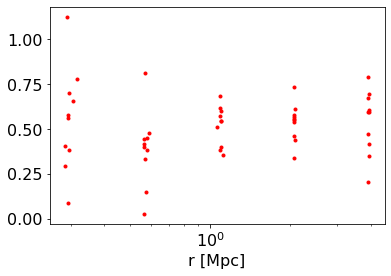

In [221]:
plt.xlabel('r [' + radial_unit + ']');
[plt.plot(mock_profiles[i]['radius'], (mock_profiles[i]['gt']/mock_profiles[i]['gt_err'])/(model/(noise*np.sqrt(1.))),'r.') for i in range(N_stack)];
plt.xscale('log')

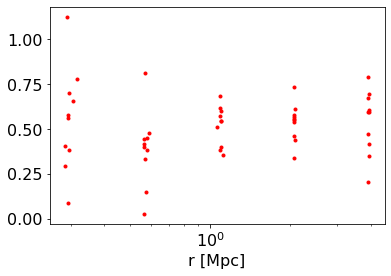

In [222]:
plt.xlabel('r [' + radial_unit + ']');
[plt.plot(mock_profiles[i]['radius'], (mock_profiles[i]['gt']/mock_profiles[i]['gt_err'])/(model/(noise*np.sqrt(1.))),'r.') for i in range(N_stack)];
plt.xscale('log')